# Tiny Imagenet

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [ ]:
import shutil,timm,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [ ]:
from fastprogress import progress_bar

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'

In [ ]:
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/tiny-imagenet-200.zip', 'data')

In [ ]:
bs = 512

In [ ]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i): return self.files[i],Path(self.files[i]).parent.parent.name

In [ ]:
tds = TinyDS(path/'train')

In [ ]:
tds[0]

('data/tiny-imagenet-200/train/n04560804/images/n04560804_203.JPEG',
 'n04560804')

In [ ]:
path_anno = path/'val'/'val_annotations.txt'
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())

In [ ]:
class TinyValDS(TinyDS):
    def __getitem__(self, i): return self.files[i],anno[os.path.basename(self.files[i])]

In [ ]:
vds = TinyValDS(path/'val')

In [ ]:
vds[0]

('data/tiny-imagenet-200/val/images/val_4619.JPEG', 'n03014705')

In [ ]:
len(tds)

100000

In [ ]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

In [ ]:
id2str = (path/'wnids.txt').read_text().splitlines()
str2id = {v:k for k,v in enumerate(id2str)}

In [ ]:
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [ ]:
def tfmx(x):
    img = read_image(x, mode=ImageReadMode.RGB)/255
    return (img-xmean[:,None,None])/xstd[:,None,None]

In [ ]:
def tfmy(y): return tensor(str2id[y])

In [ ]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [ ]:
xi,yi = tfm_tds[0]
id2str[yi]

'n04560804'

In [ ]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

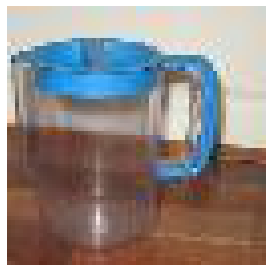

In [ ]:
show_image(denorm(xi));

In [ ]:
dltrn = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=0)

In [ ]:
xb,yb = b = next(iter(dltrn))

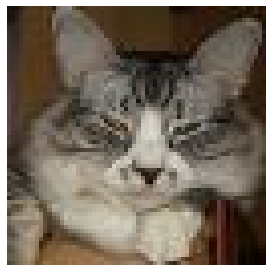

In [ ]:
show_image(denorm(xb[0]));

In [ ]:
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

In [ ]:
titles = [synsets[id2str[o]] for o in yb]
', '.join(titles[:20])

'Egyptian cat, cliff, guacamole, brass, monarch, cliff dwelling, teapot, wok, European fire salamander, bucket, pole, wok, lion, vestment, parking meter, black stork, cliff, iPod, Arabian camel, butcher shop'

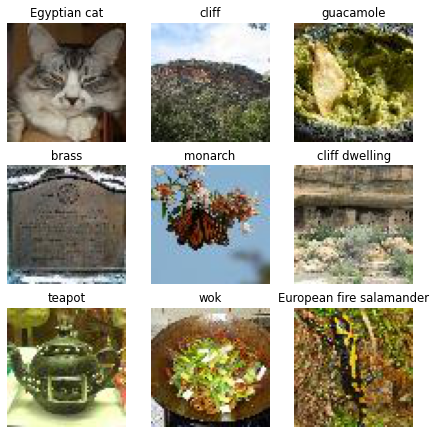

In [ ]:
show_images(denorm(xb[:9]), titles=titles[:9], imsize=2.5)

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [ ]:
tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     RandErase())#pct=0.25, max_num=7))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [ ]:
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    layers = [conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
              conv(nf, nf, stride=1, act=None, norm=norm, ks=ks)]
    if stride>1: layers.append(nn.AvgPool2d(stride))
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==0 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

In [ ]:
nfs = (32,64,128,256,512,1024)
# nbks = (2,2,1,1,1)
nbks = (3,2,2,1,1)

def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

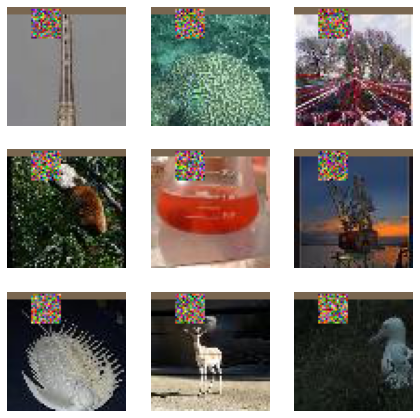

In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
opt_func = partial(optim.AdamW, eps=1e-5)

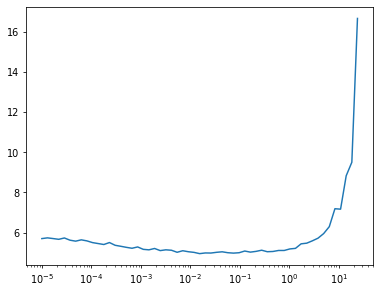

In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[DeviceCB(), augcb, ProgressCB()], opt_func=opt_func)
learn.lr_find()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

epochs = 25
lr = 3e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.073,4.595,0,train
0.099,4.283,0,eval
0.175,3.825,1,train
0.192,3.682,1,eval
0.238,3.393,2,train
0.203,3.798,2,eval
0.291,3.075,3,train
0.248,3.404,3,eval
0.329,2.873,4,train
0.275,3.290,4,eval


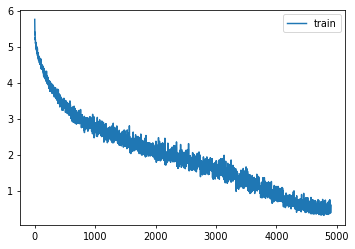

In [ ]:
learn.fit(epochs)

accuracy,loss,epoch,train
0.059,4.707,0,train
0.084,4.348,0,eval
0.140,4.048,1,train
0.151,3.921,1,eval
0.198,3.643,2,train
0.207,3.641,2,eval
0.241,3.368,3,train
0.235,3.468,3,eval
0.273,3.177,4,train
0.263,3.341,4,eval


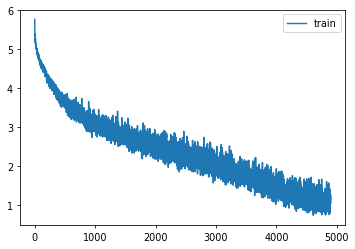

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/inettiny-custom-25')